In [2]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

import pickle

%run -i 'model_helpers.py'
%run -i 'models.py'

In [3]:
df = load_query_avg_data_exp2() # see data_helpers.py
df = df[df["condition"]!=2] # filter out "warm/snowy" as per paper
df.head()


,ID,condition,querytype,querydetail,estimate
0,0,0,A,windy,0.733333
1,0,0,AandB,windy and cloudy,0.773333
2,0,0,AandnotB,windy and not cloudy,0.676667
3,0,0,AgB,windy given cloudy,0.816667
4,0,0,AgnotB,windy given not cloudy,0.600000


In [4]:
X_data, y_data = make_model_data(df) # see data_helpers.py
print(len(y_data), "observations")

3360 observations


# Relative Frequency model

First we implement the relative frequency model. This is essentially the "null" model we need to compare the competing theories against to make sure they are really substantively improving things.

In [5]:
mcmc_rf = MCMC(NUTS(relative_freq, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_rf.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

AttributeError: Can't pickle local object 'hmc.<locals>.init_kernel'

Participant mean response corr =  0.516
Query-level corr 0.639


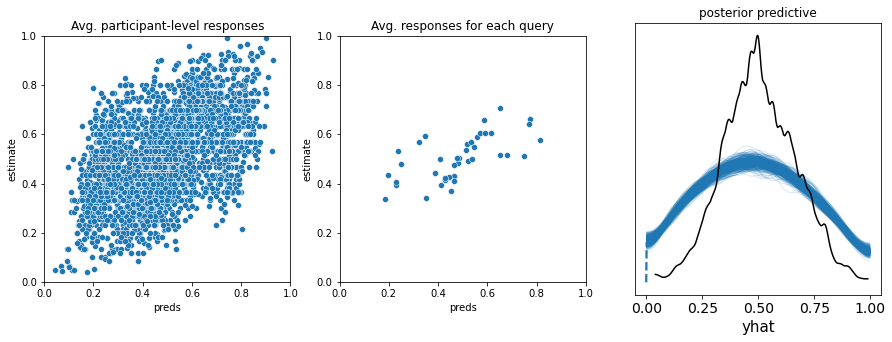

In [6]:
az_data_rf = make_arviz_data(mcmc_rf, relative_freq, X_data) # see model_helpers.py
plot_model_preds(df, az_data_rf)

In [7]:
pickle.dump(az_data_rf, open("local/exp2/az_data_rf.p", "wb"))

# Bayesian sampler model

Here I implement the Bayesian Sampler model as expressed in the Zhu et al. (2020) paper. The only difference is I parameterize it directly in terms of implied $d$ so that it can be more fairly compared with the PT+N model. 

## Simple

First, I implement the simple model with only one $d$ value for each participant. Here implied $d \in [0,\frac{1}{3}]$, reflecting the class of "ignorance priors" for the underlying Bayesian Sampler model.

In [8]:
mcmc_bs_simple = MCMC(NUTS(bayesian_sampler_simple, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.667
Query-level corr 0.831


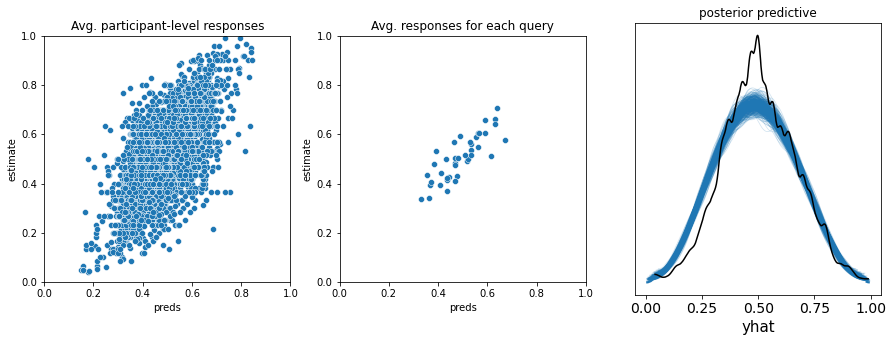

In [9]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_simple)

In [10]:
pickle.dump(az_data_bs_simple, open("local/exp2/az_data_bs_simple.p", "wb"))

## Complex

Then I implement the complex version with both $d$ and $d'$ values for conjunctive/disjunctive trials.

In [11]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.679
Query-level corr 0.848


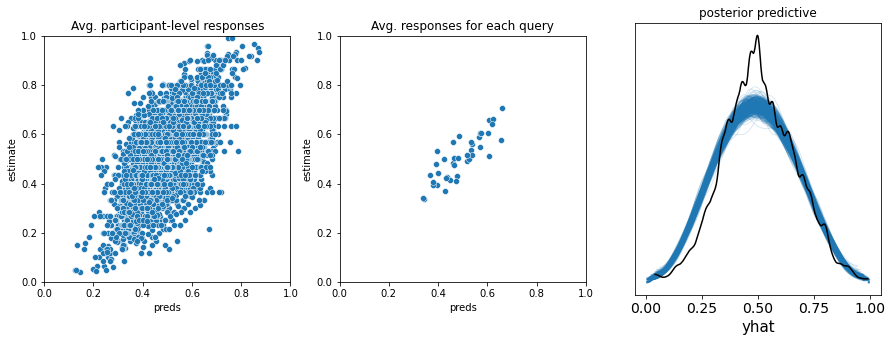

In [12]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex, X_data) # see model_helpers.py
pickle.dump(az_data_bs, open("local/exp2/az_data_bs.p", "wb"))
plot_model_preds(df, az_data_bs)

# Probability theory plus noise (PT+N) model

Then I implement the probability theory plus noise model following Costello and Watts (2017).

## Simple

First with just $d$ for each participant, constrained to fall in $d \in [0, .50]$.

In [13]:
mcmc_ptn_simple = MCMC(NUTS(PTN_simple, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_ptn_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.619
Query-level corr 0.777


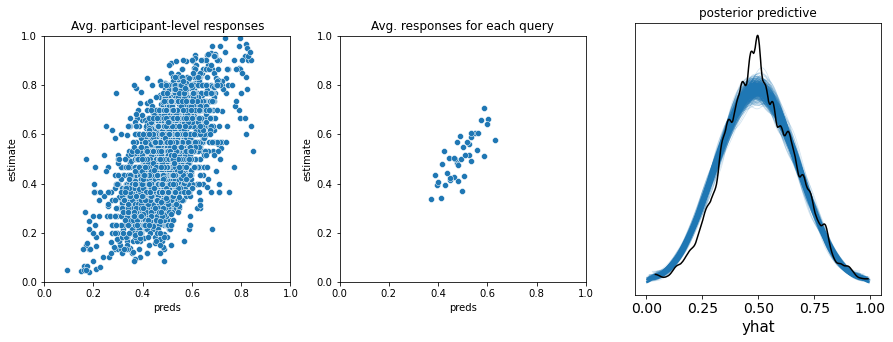

In [14]:
az_data_ptn_simple = make_arviz_data(mcmc_ptn_simple, PTN_simple, X_data) # see model_helpers.py
pickle.dump(az_data_ptn_simple, open("local/exp2/az_data_ptn_simple.p", "wb"))
plot_model_preds(df, az_data_ptn_simple)

## Complex

Then with $d$ and $d'$ for each participant.

In [15]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [16]:
# mcmc_ptn.print_summary()

Participant mean response corr =  0.667
Query-level corr 0.84


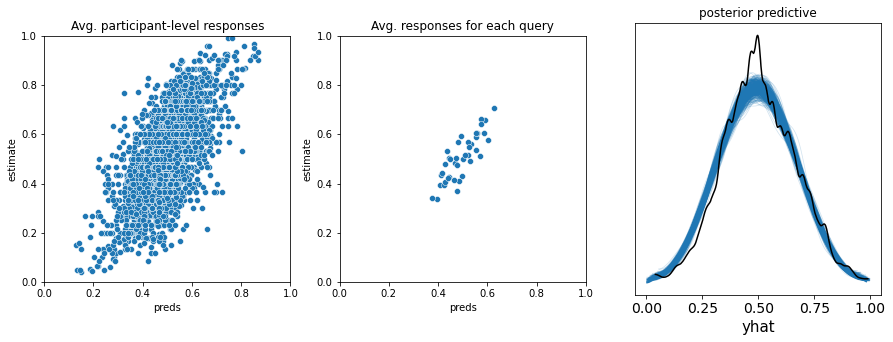

In [17]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex, X_data) # see model_helpers.py
pickle.dump(az_data_ptn, open("local/exp2/az_data_ptn.p", "wb"))
plot_model_preds(df, az_data_ptn)

In [18]:
az.compare(
    {
        "P+TN complex":az_data_ptn, 
        "Bayesian Sampler complex": az_data_bs, 
        "P+TN simple":az_data_ptn_simple, 
        "Bayesian Sampler simple": az_data_bs_simple, 
        "Relative Freq.":az_data_rf
    }, 
    scale="deviance", ic="loo")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
P+TN complex,0,-3768.475459,398.176587,0.000000,0.548851,82.139180,0.000000,True,deviance
Bayesian Sampler complex,1,-3733.245199,453.641763,35.230260,0.139312,83.899120,36.717929,True,deviance
Bayesian Sampler simple,2,-3722.790631,418.892665,45.684828,0.310858,83.154651,40.370050,True,deviance
P+TN simple,3,-3643.007238,319.493928,125.468221,0.000000,82.209217,29.934827,False,deviance
Relative Freq.,4,-1287.697861,424.635945,2480.777598,0.000980,92.153069,90.966146,False,deviance


NOTE: There there are some "very bad" samples, so should run `reloo()` to fix those, following this [arviz tutorial](https://arviz-devs.github.io/arviz/user_guide/numpyro_refitting_xr_lik.html) (per this [stackoverflow post](https://stats.stackexchange.com/questions/304958/warnings-during-waic-computation-how-to-proceed)). Unfortunately this is a bit tricky/not fully documented for Arviz, making it infeasible to implement at this time.


# Summary and comparison of models

All three models have now been implemented as probabilistic programs, and we have obtained samples for each. [This paper](https://arxiv.org/abs/1507.04544) describes how to compare them using information criteria.

* Both the PT+N and Bayesian sampler models are far better than the naive relative frequency model.
* The two models cannot really be distinguished reliably from one another however.

# Hierarchical Bayesian Sampler

Unpooled models may be overpenalized for complexity if the heterogenity among participants is actually low. Here I implement hierarchical versions of the PT+N and Bayesian Sampler models that impelement partial pooling. This allows for sharing of information and potentially reduced model complexity.

## Simple

First, a hierarchical version with a population level $d$ and subject-level $d_{subj}$ parameters.


In [19]:
mcmc_bs_mlm_simple = MCMC(NUTS(bayesian_sampler_simple_mlm_d, target_accept_prob=.95), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)
# 
mcmc_bs_mlm_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.667
Query-level corr 0.839


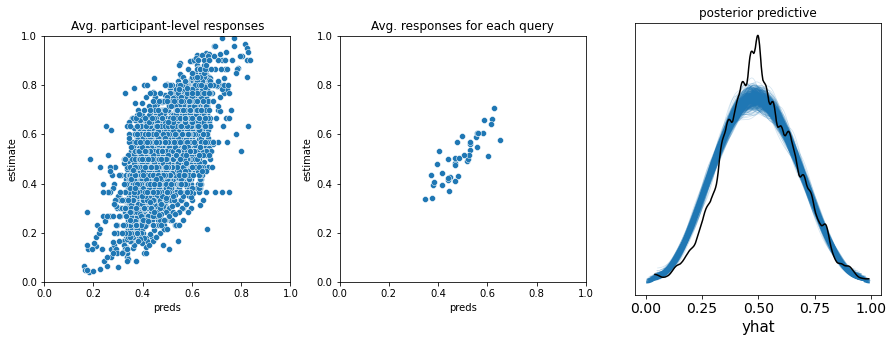

In [20]:
az_data_bs_mlm_simple = make_arviz_data(mcmc_bs_mlm_simple, bayesian_sampler_simple_mlm_d, X_data) # see model_helpers.py
pickle.dump(az_data_bs_mlm_simple, open("local/exp2/az_data_bs_mlm_simple.p", "wb"))
plot_model_preds(df, az_data_bs_mlm_simple)

In [21]:
az.summary(az_data_bs_mlm_simple, var_names=['d_base_sd','d_base_pop'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,2.030,0.351,1.409,2.696,0.007,0.005,2695.0,3731.0,1.0
d_base_pop,3.988,0.410,3.249,4.786,0.006,0.004,5195.0,5507.0,1.0


## Complex

Then, a complex version with $d$ and $d'$ and subject-level $d_{subj}$ and $d'_{subj}$ parameters.

In [22]:
mcmc_bs_mlm = MCMC(NUTS(bayesian_sampler_complex_mlm_d, target_accept_prob=.95), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)
# 
mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.675
Query-level corr 0.852


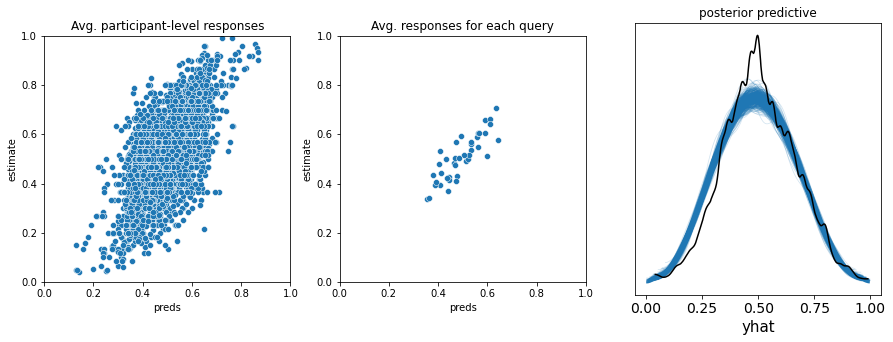

In [23]:
az_data_bs_mlm = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm_d, X_data) # see model_helpers.py
pickle.dump(az_data_bs_mlm, open("local/exp2/az_data_bs_mlm.p", "wb"))
plot_model_preds(df, az_data_bs_mlm)

In [24]:
az.summary(az_data_bs_mlm, var_names=['d_base_sd', 'd_delta_sd', 'd_delta_pop', 'd_base_pop'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.866,0.342,1.231,2.492,0.007,0.005,2401.0,4350.0,1.0
d_delta_sd,0.396,0.341,0.015,0.958,0.005,0.004,3638.0,5470.0,1.0
d_delta_pop,0.529,0.264,0.024,1.017,0.004,0.003,4408.0,4983.0,1.0
d_base_pop,3.023,0.399,2.283,3.756,0.007,0.005,3148.0,4679.0,1.0


# Hierarchical PT+N

## Simple

<!-- # Hierarchical PT+N -->


In [5]:
mcmc_ptn_mlm_simple = MCMC(NUTS(PTN_simple_mlm, target_accept_prob=.95), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_ptn_mlm_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.617
Query-level corr 0.772


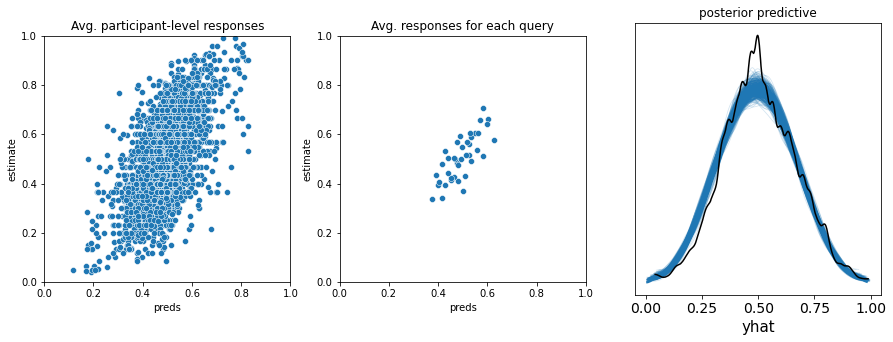

In [6]:
az_data_ptn_mlm_simple = make_arviz_data(mcmc_ptn_mlm_simple, PTN_simple_mlm, X_data) # see model_helpers.py
pickle.dump(az_data_ptn_mlm_simple, open("local/exp2/mcmc_ptn_mlm_simple.p", "wb"))
plot_model_preds(df, az_data_ptn_mlm_simple)

## Complex

In [28]:
mcmc_ptn_mlm = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.95), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_ptn_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [29]:
# mcmc_ptn_mlm.print_summary()

Participant mean response corr =  0.658
Query-level corr 0.835


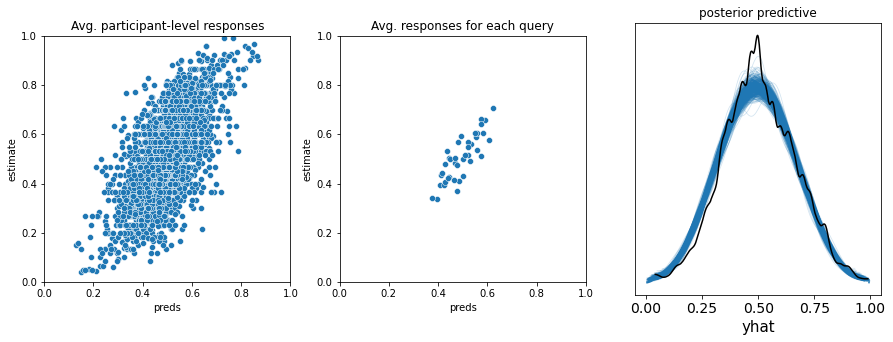

In [30]:
az_data_ptn_mlm = make_arviz_data(mcmc_ptn_mlm, PTN_complex_mlm, X_data) # see model_helpers.py
pickle.dump(az_data_ptn_mlm, open("local/exp2/az_data_ptn_mlm.p", "wb"))
plot_model_preds(df, az_data_ptn_mlm)

# "Hybrid" —unconstrainted $\beta$ or PT+N without conditional probability account

In [31]:
# %run -i 'models.py'
mcmc_ptn_mlm_simplecond = MCMC(NUTS(PTN_complex_mlm_simplecond, target_accept_prob=.95), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_ptn_mlm_simplecond.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.688
Query-level corr 0.878


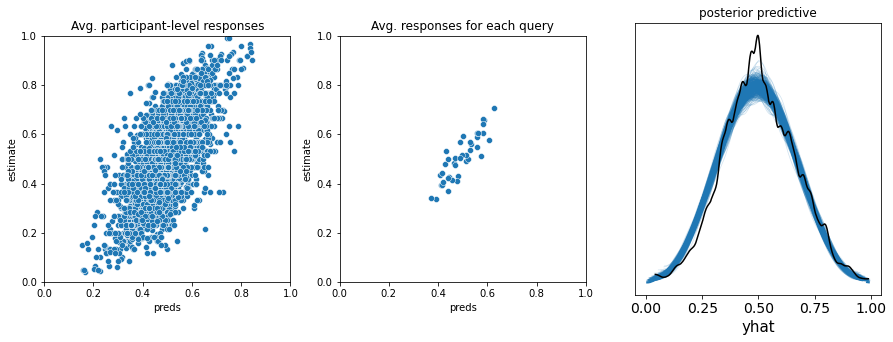

In [32]:
az_data_ptn_mlm_simplecond = make_arviz_data(mcmc_ptn_mlm_simplecond, PTN_complex_mlm_simplecond, X_data) # see model_helpers.py
pickle.dump(az_data_ptn_mlm_simplecond, open("local/exp2/az_data_ptn_mlm_simplecond.p", "wb"))
plot_model_preds(df, az_data_ptn_mlm_simplecond)

In [189]:
exp2_model_comparison = az.compare(
    {
        "P+TN complex":az_data_ptn, 
        "Bayesian Sampler complex": az_data_bs, 
        "P+TN simple":az_data_ptn_simple, 
        "Bayesian Sampler simple": az_data_bs_simple, 
        "Relative Freq.":az_data_rf,
        "PT+N complex mlm":az_data_ptn_mlm, 
        "PT+N simple mlm":az_data_ptn_mlm_simple, 
        "Bayesian Sampler complex mlm": az_data_bs_mlm,
        "Bayesian Sampler simple mlm": az_data_bs_mlm_simple,
        "Hybrid mlm": az_data_ptn_mlm_simplecond
    }, 
    scale="deviance", ic="loo")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen w

In [194]:
# model_comp_output = exp2_model_comparison.drop(["weight","se","warning","loo_scale"])

# with open('local/exp2_model_comparison.tex', 'w') as tf:
#      tf.write(model_comp_output.to_latex())
        
exp2_model_comparison

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,model
Hybrid mlm,0,-3953.115551,368.747360,0.000000,9.907450e-01,80.386416,0.000000,True,deviance,Hybrid mlm
Bayesian Sampler complex mlm,1,-3815.403502,399.897568,137.712049,9.067268e-09,81.357934,22.568819,True,deviance,Bayesian Sampler complex mlm
PT+N complex mlm,2,-3796.743712,356.084049,156.371839,9.243525e-09,80.962585,21.495246,True,deviance,PT+N complex mlm
Bayesian Sampler simple mlm,3,-3794.707245,381.027724,158.408306,9.001978e-09,81.051112,25.461823,True,deviance,Bayesian Sampler simple mlm
P+TN complex,4,-3768.475459,398.176587,184.640092,9.361211e-09,82.139180,22.947907,True,deviance,P+TN complex
Bayesian Sampler complex,5,-3733.245199,453.641763,219.870352,9.239725e-09,83.899120,27.260197,True,deviance,Bayesian Sampler complex
Bayesian Sampler simple,6,-3722.790631,418.892665,230.324920,9.127229e-09,83.154651,29.749158,True,deviance,Bayesian Sampler simple
PT+N simple mlm,7,-3643.970838,305.092027,309.144713,5.284319e-03,81.178798,35.052256,False,deviance,PT+N simple mlm
P+TN simple,8,-3643.007238,319.493928,310.108313,8.992777e-09,82.209217,34.899593,False,deviance,P+TN simple
Relative Freq.,9,-1287.697861,424.635945,2665.417690,3.970624e-03,92.153069,88.225953,False,deviance,Relative Freq.


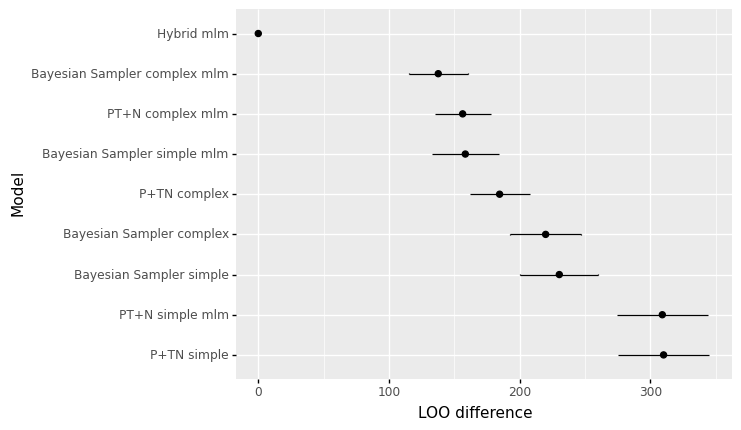

<ggplot: (8730608672425)>

In [193]:
from plotnine import *
import siuba as s
from siuba import _

exp2_model_comparison["model"] = exp2_model_comparison.index

(
    exp2_model_comparison >>
    s.filter(_.model!="Relative Freq.") >>
    s.mutate(ul = _.d_loo + _.dse, ll = _.d_loo - _.dse) >>
    ggplot(aes(y="reorder(model, -d_loo)",  x= "d_loo", xmin="ll", xmax="ul")) +
    geom_point(size=2) +
    geom_errorbarh(height=.01, size=.5) +
    labs(x = "LOO difference", y = "Model")
)

Interesting that the restricted complex Bayesian Sampler has a higher penalty term than the unrestricted version. Otherwise the relative complexities seem roughly intuitive. ~~Maybe it has something to do with the $\theta$? Or maybe all the random effects are closer to zero when they aren't restricted?~~ I bet it is because the constraint on d and d' are encouraging pretty extreme values for the parameters on the linear scale, which is making that greater in terms of effective parameters.

Even though the models all seem relatively similar, there are pretty big differences in their predictive power! Comparing best to worse, there is about 17% more variance accounted for in condition means, and about 9% more in participant-level responses. 

# Comparing conditional probability judgments

Bayesian Sampler conditional response corr =  0.7198
Bayesian Sampler conditional query-level corr 0.922


<AxesSubplot:xlabel='preds', ylabel='estimate'>

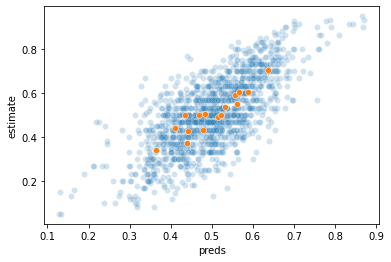

In [202]:
# zoom in on conditional trials

d = df
d["preds"] = az_data_bs_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]
trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("Bayesian Sampler conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],4))
sns.scatterplot(x = d.preds, y = d.estimate, alpha=.2)
print("Bayesian Sampler conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],4))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

PT+N conditional response corr =  0.6704
PT+N conditional query-level corr 0.8543


<AxesSubplot:xlabel='preds', ylabel='estimate'>

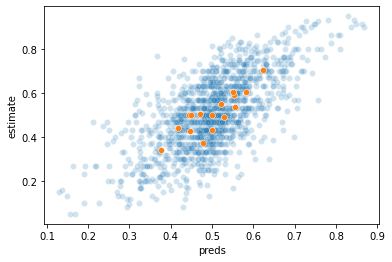

In [203]:
d = df
d["preds"] = az_data_ptn_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]

trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("PT+N conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],4))
sns.scatterplot(x = d.preds, y = d.estimate, alpha=.2)
print("PT+N conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],4))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

Descriptively, the Bayesian Sampler does a better job predicting for conditional trials than does the PT+N model. That's consistent with the the diagnosis that the problem with the PT+N model is its account of conditional probability judgments, although the Bayesian sampler model is also showing a better correlation for non-conditional judgments. My guess there is the estimation of the PT+N model parameters are being biased by its incorrect specification for conditional probability trials.

# Summary of hierarchical models

If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then a hierarchical implementation of that model pulls ahead of a hierarchical implementation of PT+N. This is equivalent to stripping out the constructive account of conditional probability judgments from PT+N.

These results are pretty decisive in favor of the Bayesian Sampler model's account of conditional probability (these judgments are just like simple probability judgments) and therefore the Bayesian Sampler theory. As for whether we should appeal to "noise" or "priors", as Zhu and colleage's point out they are essentially indistinguishable at this point. Certain degrees of noise act like certain priors, and vice versa.

### A few concerns

* Should do more formal prior predictive checks to make sure I am giving more-or-less uninformative priors — however this should be irrelevant to model comparison b/c they are equated.

# Inspecting the models

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

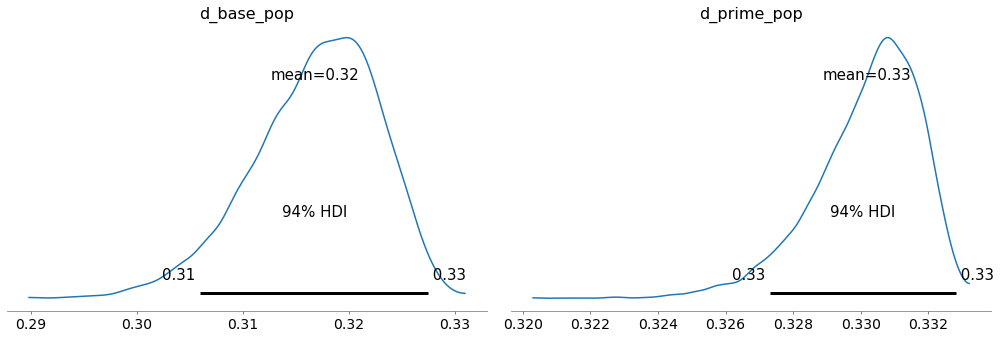

In [36]:
# az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_pop"], transform=np.exp)
# # az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_sd", "N_prime_sd", "N_delta_sd"], transform=np.exp)

# az_data_bs_mlm.posterior["N_base_pop"] = 1 + np.exp(az_data_bs_mlm.posterior.N_prime_pop) + np.exp(az_data_bs_mlm.posterior.N_delta_pop)
# az.plot_posterior(az_data_bs_mlm, var_names=["N_base_pop"])
# az.plot_posterior(az_data_bs_mlm, var_names=["N_prime_pop"], transform = lambda x: 1 + np.exp(x))

## Implied d
az_data_bs_mlm.posterior["d_prime_pop"] = az_data_bs_mlm.posterior.d_base_pop + np.exp(az_data_bs_mlm.posterior.d_delta_pop)
az.plot_posterior(az_data_bs_mlm, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/3.)


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

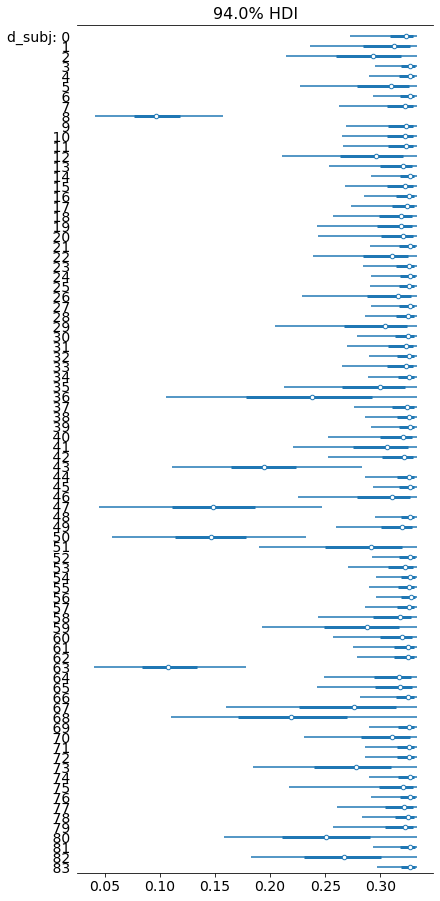

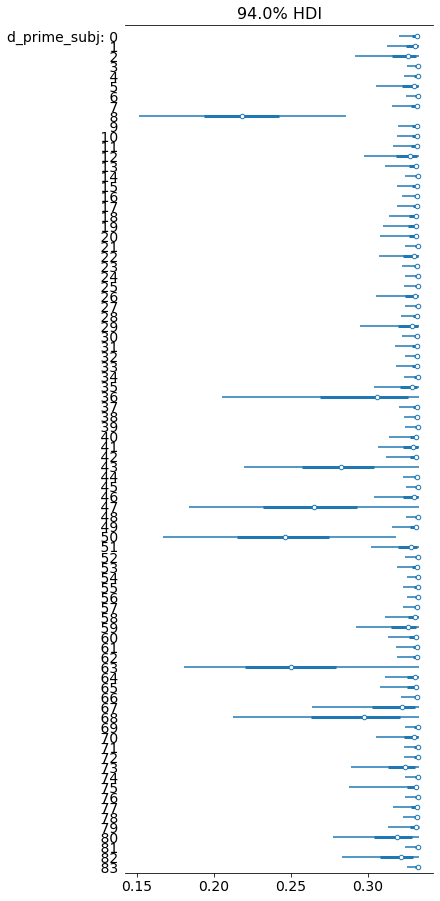

In [37]:
# az.plot_forest(data=az_data_bs_mlm, var_names=["beta_subj"],  combined=True)
# az.plot_forest(data=az_data_bs_mlm, var_names=["N_subj"], combined=True)
# az.plot_forest(data=az_data_bs_mlm, var_names=["N_prime_subj"], combined=True)

## implied d
az.plot_forest(data=az_data_bs_mlm, var_names=["d_subj"], combined=True)
az.plot_forest(data=az_data_bs_mlm, var_names=["d_prime_subj"], combined=True)

In [38]:
print("num divergences =", count_divergences(az_data_bs_mlm))
az.summary(az_data_bs_mlm, var_names=['d_base_sd','d_delta_sd'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.866,0.342,1.231,2.492,0.007,0.005,2401.0,4350.0,1.0
d_delta_sd,0.396,0.341,0.015,0.958,0.005,0.004,3638.0,5470.0,1.0


In [39]:
print("num divergences =", count_divergences(az_data_ptn_mlm_simplecond))
az.summary(az_data_ptn_mlm_simplecond, var_names=['d_base_sd','d_delta_sd'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,0.808,0.103,0.624,1.003,0.002,0.002,2006.0,3287.0,1.0
d_delta_sd,0.205,0.128,0.020,0.437,0.002,0.001,3769.0,4997.0,1.0


In [40]:
print("num divergences =", count_divergences(az_data_ptn_mlm))
az.summary(az_data_ptn_mlm, var_names=['d_base_sd','d_delta_sd'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,0.991,0.124,0.760,1.223,0.003,0.002,2214.0,3999.0,1.0
d_delta_sd,0.186,0.109,0.022,0.382,0.002,0.001,2894.0,4541.0,1.0


Random effect stuff isn't sampling well. But it looks like it sort of explains why BS is more complex, has larger random effect SD.

## PT+N

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

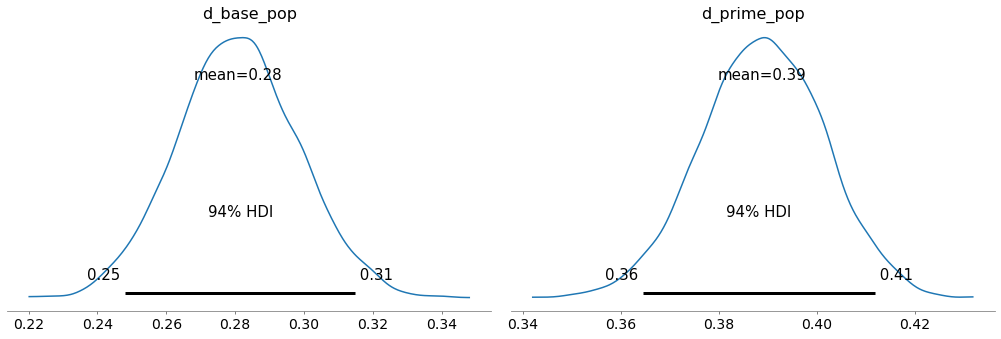

In [41]:
az_data_ptn_mlm.posterior["d_prime_pop"] = az_data_ptn_mlm.posterior.d_base_pop + np.exp(az_data_ptn_mlm.posterior.d_delta_pop)
az.plot_posterior(az_data_ptn_mlm, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

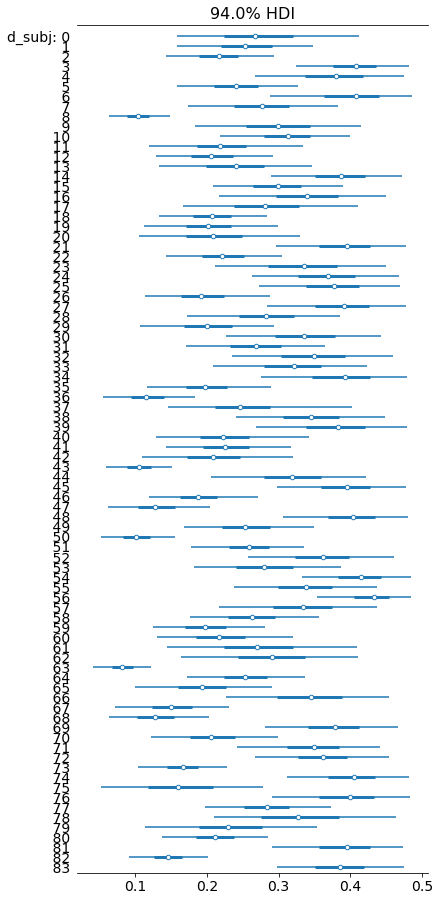

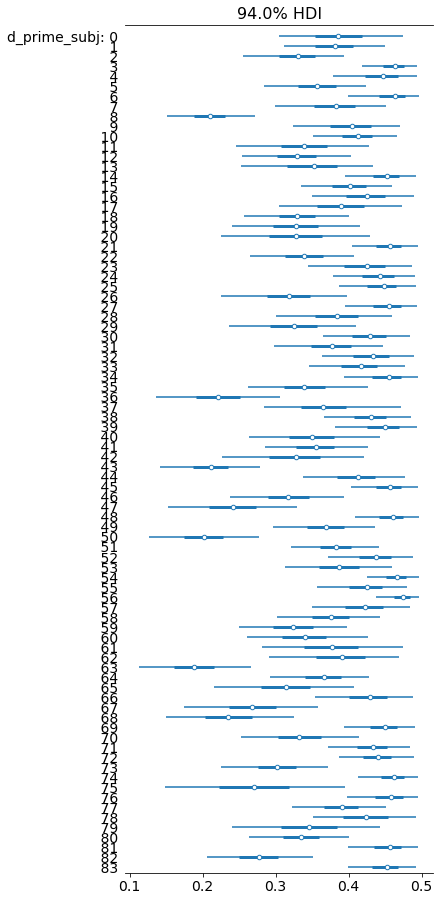

In [42]:
az.plot_forest(data=az_data_ptn_mlm, var_names=["d_subj"], combined=True)
az.plot_forest(data=az_data_ptn_mlm, var_names=["d_prime_subj"], combined=True)

# Hybrid

In [204]:
az.summary(
    az_data_ptn_mlm_simplecond,
    var_names = ["d_base_sd", "d_delta_sd"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,0.808,0.103,0.624,1.003,0.002,0.002,2006.0,3287.0,1.0
d_delta_sd,0.205,0.128,0.020,0.437,0.002,0.001,3769.0,4997.0,1.0


array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

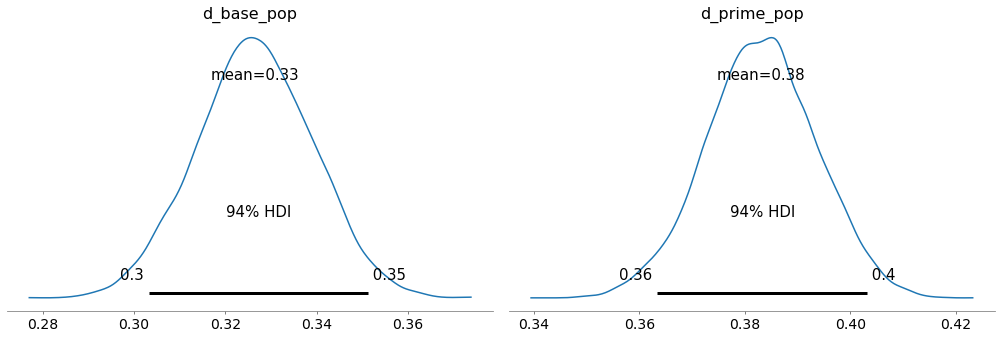

In [43]:
az_data_ptn_mlm_simplecond.posterior["d_prime_pop"] = az_data_ptn_mlm_simplecond.posterior.d_base_pop + np.exp(az_data_ptn_mlm_simplecond.posterior.d_delta_pop)
az.plot_posterior(az_data_ptn_mlm_simplecond, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

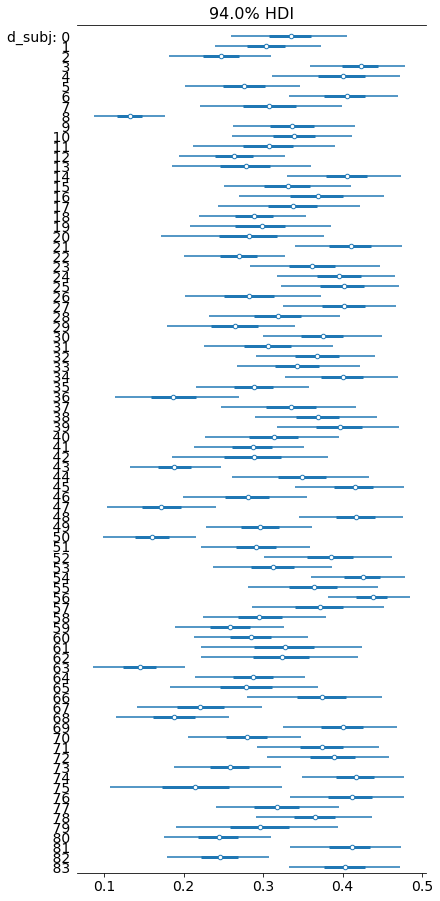

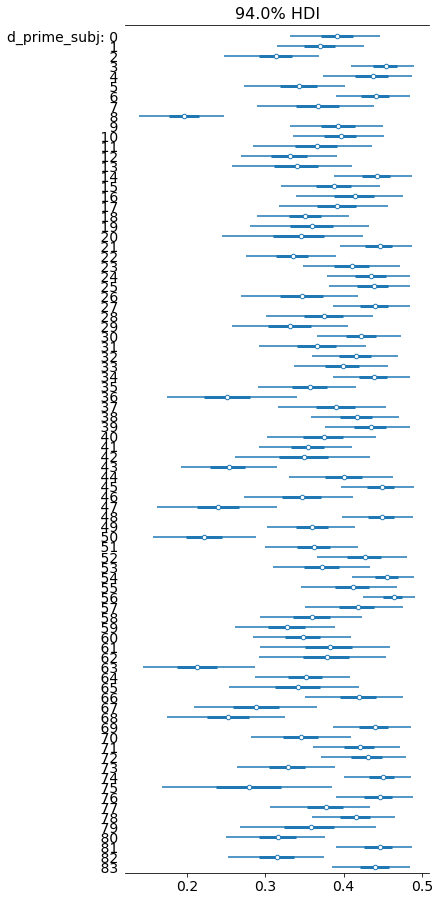

In [44]:
az.plot_forest(data=az_data_ptn_mlm_simplecond, var_names=["d_subj"], combined=True)
az.plot_forest(data=az_data_ptn_mlm_simplecond, var_names=["d_prime_subj"], combined=True)

# Prior checks

It's not possible to have uniform priors for both d and d'. These priors are as close to uniform as I could get though at the subject-level, being nearly uniform for d'.

<AxesSubplot:xlabel='d_subj', ylabel='Density'>

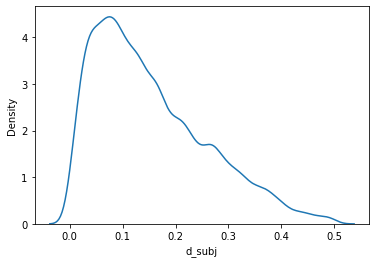

In [241]:
x = az_data_ptn_mlm_simplecond.prior.stack(draws=("chain","draw","d_subj_dim_0"))
sns.kdeplot(x["d_subj"])

<AxesSubplot:xlabel='d_prime_subj', ylabel='Density'>

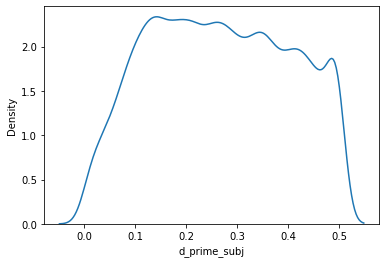

In [242]:
x = az_data_ptn_mlm_simplecond.prior.stack(draws=("chain","draw","d_prime_subj_dim_0"))
sns.kdeplot(x["d_prime_subj"])

## BELOW MIGHT NOT BE WORKING 5/14/21, 4:39 PM

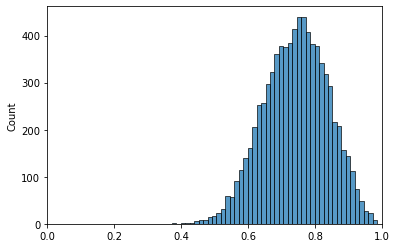

In [219]:
# looking at the inferred thetas
import matplotlib.pyplot as plt

stacked = az_data_ptn_mlm_simplecond.posterior.stack(draws=("chain", "draw"))

def calc_implied_prob(query, posterior):
    x = jnp.transpose(jnp.array(posterior))
    return(calc_prob_trial(query, x))


sns.histplot(calc_implied_prob("AandB", stacked.theta[4,:]))
plt.xlim(0,1)
plt.show()

Some of the subj with low d and d' have very noisy probability estimates. So that's not necessarily a sign of "clean" responding.

<AxesSubplot:ylabel='Count'>

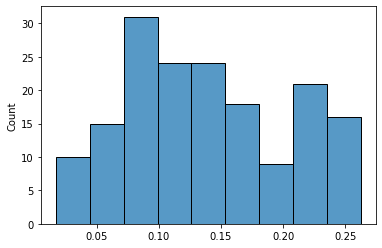

In [216]:
# could calculate standard dev of all posteriors for simple A and B probs

c1_sd = jnp.array([np.std(calc_implied_prob("AgB", stacked.theta[i,:])) for i in range(0,168)])
sns.histplot(c1_sd)

<AxesSubplot:ylabel='Count'>

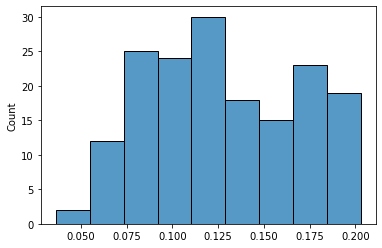

In [153]:
c2_sd = jnp.array([np.std(calc_implied_prob("B", stacked.theta[i,:])) for i in range(0,168)])
sns.histplot(c2_sd)

A bit hard to interpret this really, but just from eyeballing some plots I'll hazard we're getting reasonably strong measurements for maybe 1/4 of responses, mediocre measures for another 1/4 and basically worthless measures for another 1/2.